In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# read 데이터
df = pd.read_csv('AFSNT.CSV', encoding="cp949")
df.head()

C:\Users\82105\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP1,ARP3,A,A1901,SEw3Nzc2,D,N,6:10,6:18,N,NaN,N,NaN
1,2017,1,1,일,ARP1,ARP3,A,A1905,SEw4MjM2,D,N,6:15,6:25,N,NaN,N,NaN
2,2017,1,1,일,ARP1,ARP3,L,L1751,SEw4MjM3,D,N,6:20,6:30,N,NaN,N,NaN
3,2017,1,1,일,ARP1,ARP3,F,F1201,SEw4MjA3,D,N,6:25,6:34,N,NaN,N,NaN
4,2017,1,1,일,ARP3,ARP1,A,A1900,SEw3NzAz,D,N,6:30,6:37,N,NaN,N,NaN


In [3]:
# 비행기 취소와 관련된 Column 삭제
df.drop(columns=['CNL', 'CNR'], axis=1, inplace=True)

# 사용되지 않을 것 같은 데이터 일단 삭제
df.drop(columns=['REG', 'IRR', 'DRR'], axis=1, inplace=True)


In [4]:
# ATT (actual time data)가 널 값인 레코드 삭제
df = df[pd.notnull(df['ATT'])]
df.isnull().sum()

SDT_YY    0
SDT_MM    0
SDT_DD    0
SDT_DY    0
ARP       0
ODP       0
FLO       0
FLT       0
AOD       0
STT       0
ATT       0
DLY       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979461 entries, 0 to 987708
Data columns (total 12 columns):
SDT_YY    979461 non-null int64
SDT_MM    979461 non-null int64
SDT_DD    979461 non-null int64
SDT_DY    979461 non-null object
ARP       979461 non-null object
ODP       979461 non-null object
FLO       979461 non-null object
FLT       979461 non-null object
AOD       979461 non-null object
STT       979461 non-null object
ATT       979461 non-null object
DLY       979461 non-null object
dtypes: int64(3), object(9)
memory usage: 97.1+ MB


In [6]:
df['SDT_YY'] = df['SDT_YY'].astype('object')
df['SDT_MM'] = df['SDT_MM'].astype('object')
df['SDT_DD'] = df['SDT_DD'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979461 entries, 0 to 987708
Data columns (total 12 columns):
SDT_YY    979461 non-null object
SDT_MM    979461 non-null object
SDT_DD    979461 non-null object
SDT_DY    979461 non-null object
ARP       979461 non-null object
ODP       979461 non-null object
FLO       979461 non-null object
FLT       979461 non-null object
AOD       979461 non-null object
STT       979461 non-null object
ATT       979461 non-null object
DLY       979461 non-null object
dtypes: object(12)
memory usage: 97.1+ MB


In [7]:
df.rename(columns={'SDT_YY':'Year', 'SDT_MM':'Month', 'SDT_DD':'DAY'}, inplace=True)
# 년월일 데이터를 날짜로 변환시킴
df['DAY'] = pd.to_datetime(df[['Year', 'Month', 'DAY']])
# 년, 월 데이터 삭제
df.drop(columns=['Year', 'Month'], axis=1, inplace=True)
print(df['DAY'].size)
df.head(30)

979461


,DAY,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,ATT,DLY
0,2017-01-01,일,ARP1,ARP3,A,A1901,D,6:10,6:18,N
1,2017-01-01,일,ARP1,ARP3,A,A1905,D,6:15,6:25,N
2,2017-01-01,일,ARP1,ARP3,L,L1751,D,6:20,6:30,N
3,2017-01-01,일,ARP1,ARP3,F,F1201,D,6:25,6:34,N
4,2017-01-01,일,ARP3,ARP1,A,A1900,D,6:30,6:37,N
5,2017-01-01,일,ARP1,ARP3,H,H1101,D,6:30,6:38,N
6,2017-01-01,일,ARP1,ARP3,I,I1301,D,6:30,6:44,N
7,2017-01-01,일,ARP1,ARP3,A,A1907,D,6:40,7:54,Y
8,2017-01-01,일,ARP1,ARP3,I,I1303,D,6:40,6:53,N
9,2017-01-01,일,ARP1,ARP3,J,J1204,D,6:45,7:02,N


In [8]:
# ARP 경로 파생변수 생성
df['ARPODP'] = df['ARP'] + '_' + df['ODP']
df.head()

,DAY,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,ATT,DLY,ARPODP
0,2017-01-01,일,ARP1,ARP3,A,A1901,D,6:10,6:18,N,ARP1_ARP3
1,2017-01-01,일,ARP1,ARP3,A,A1905,D,6:15,6:25,N,ARP1_ARP3
2,2017-01-01,일,ARP1,ARP3,L,L1751,D,6:20,6:30,N,ARP1_ARP3
3,2017-01-01,일,ARP1,ARP3,F,F1201,D,6:25,6:34,N,ARP1_ARP3
4,2017-01-01,일,ARP3,ARP1,A,A1900,D,6:30,6:37,N,ARP3_ARP1


In [9]:
# Categorical data --> one hot encoding

one_hot_dy = pd.get_dummies(df['SDT_DY'])
df = df.drop(['SDT_DY'],axis = 1)
df = df.join(one_hot_dy)

one_hot_arp = pd.get_dummies(df['ARP'])
df = df.drop(['ARP'],axis = 1)
df = df.join(one_hot_arp)

one_hot_flo = pd.get_dummies(df['FLO'])
df = df.drop(['FLO'],axis = 1)
df = df.join(one_hot_flo)

one_hot_odp = pd.get_dummies(df['ODP'])
df = df.drop(['ODP'],axis = 1)
one_hot_odp.rename(columns={'ARP1':'ARP1_','ARP2':'ARP2_','ARP3':'ARP3_','ARP4':'ARP4_','ARP5':'ARP5_',
                            'ARP14':'ARP14_','ARP12':'ARP12_','ARP10':'ARP10_','ARP8':'ARP8_','ARP6':'ARP6_',
                            'ARP15':'ARP15_','ARP13':'ARP13_','ARP11':'ARP11_','ARP9':'ARP9_','ARP7':'ARP7_'
                  }, inplace=True)
df = df.join(one_hot_odp)

one_hot_arpodp = pd.get_dummies(df['ARPODP'])
df = df.drop(['ARPODP'],axis = 1)
df = df.join(one_hot_arpodp)

print(len(df.columns)) 

140


In [10]:
from datetime import datetime, date

df['Diff'] = (pd.to_datetime(df['ATT'],format= '%H:%M') - pd.to_datetime(df['STT'],format= '%H:%M')).dt.seconds.astype('int64')

df.head(10)

,DAY,FLT,AOD,STT,ATT,DLY,금,목,수,월,...,ARP8_ARP15,ARP8_ARP2,ARP8_ARP3,ARP8_ARP7,ARP9_ARP1,ARP9_ARP15,ARP9_ARP2,ARP9_ARP3,ARP9_ARP6,Diff
0,2017-01-01,A1901,D,6:10,6:18,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,480
1,2017-01-01,A1905,D,6:15,6:25,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,600
2,2017-01-01,L1751,D,6:20,6:30,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,600
3,2017-01-01,F1201,D,6:25,6:34,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,540
4,2017-01-01,A1900,D,6:30,6:37,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,420
5,2017-01-01,H1101,D,6:30,6:38,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,480
6,2017-01-01,I1301,D,6:30,6:44,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,840
7,2017-01-01,A1907,D,6:40,7:54,Y,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4440
8,2017-01-01,I1303,D,6:40,6:53,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,780
9,2017-01-01,J1204,D,6:45,7:02,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1020


In [11]:
########################################################################출발
# 딜레이가 최대 5시간이라고 가정했을 때, --> 즉, 2시간 초과한 딜레이는 wrong값이라 가정
max_delay_hour = 5
max_delay = max_delay_hour * 3600 # seconds

# 출발비행기의 경우, 조금이라도 출발이 빠른 건 wrong data라 판단.
# 7200보다 큰 값을 가지는 Diff 데이터 wrong 값 처리
df = df[((df['Diff'] <= max_delay) & (df['AOD']=='D')) | (df['AOD']=='A')]

df.head(100)

########################################################################도착
#이정도는 늦게 도착해도 O
#2시간은 예상보다 늦게도착할 수 있다. 그 이상은 말이안된다
max_delay_hour_arr = 5
max_delay_arr = max_delay_hour_arr * 3600 # seconds

#몇분 일찍도착해도 O
#30분은 예상보다 빨리도착할 수 있음. 그거보다 빨리도착하는 건 말이 안됨
min_delay = 30*60
min_delay = 86400 - min_delay  # 86400(24시간)보다 위인거만 살려놓기
df = df[(df['AOD']=='D') |((df['Diff'] <= max_delay_arr) & (df['AOD']=='A')) | ((df['AOD']=='A')& (df['Diff'] >= min_delay )) ]
df.loc[df['Diff'] >=min_delay, 'Diff'] = df.loc[df['Diff'] >=min_delay, 'Diff']  - 86400
df.head(100)

,DAY,FLT,AOD,STT,ATT,DLY,금,목,수,월,...,ARP8_ARP15,ARP8_ARP2,ARP8_ARP3,ARP8_ARP7,ARP9_ARP1,ARP9_ARP15,ARP9_ARP2,ARP9_ARP3,ARP9_ARP6,Diff
0,2017-01-01,A1901,D,6:10,6:18,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,480
1,2017-01-01,A1905,D,6:15,6:25,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,600
2,2017-01-01,L1751,D,6:20,6:30,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,600
3,2017-01-01,F1201,D,6:25,6:34,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,540
4,2017-01-01,A1900,D,6:30,6:37,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,420
5,2017-01-01,H1101,D,6:30,6:38,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,480
6,2017-01-01,I1301,D,6:30,6:44,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,840
7,2017-01-01,A1907,D,6:40,7:54,Y,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4440
8,2017-01-01,I1303,D,6:40,6:53,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,780
9,2017-01-01,J1204,D,6:45,7:02,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1020


['Diff']
**************************************************
All


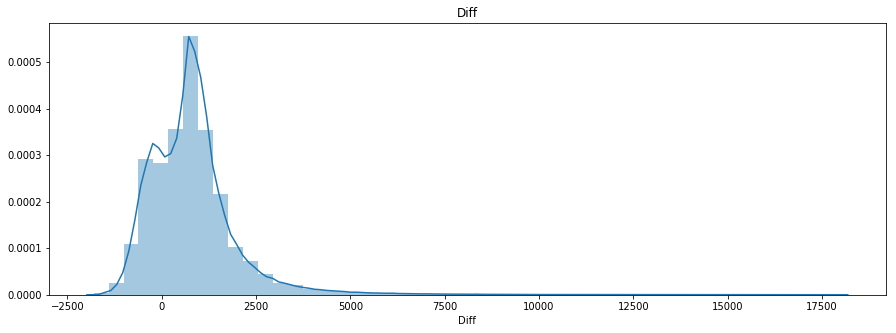

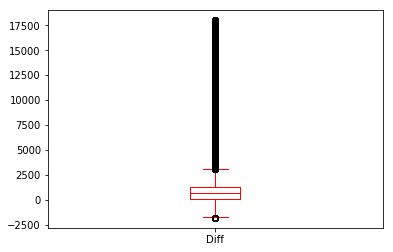

**************************************************
Arrive


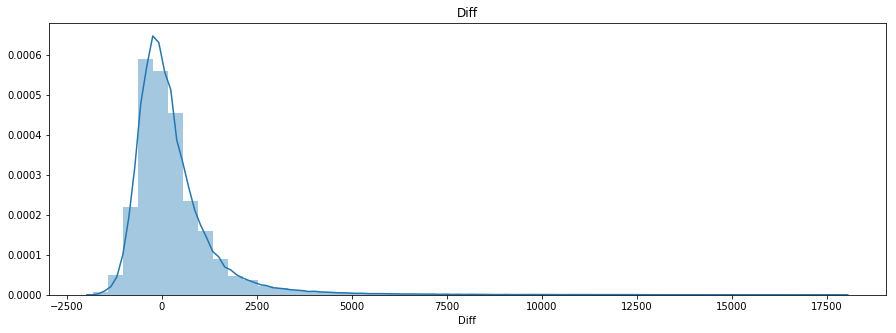

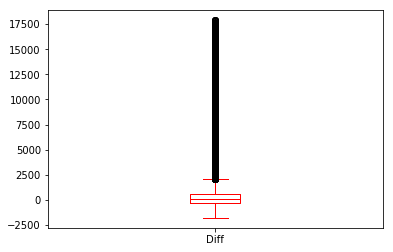

**************************************************
Departure


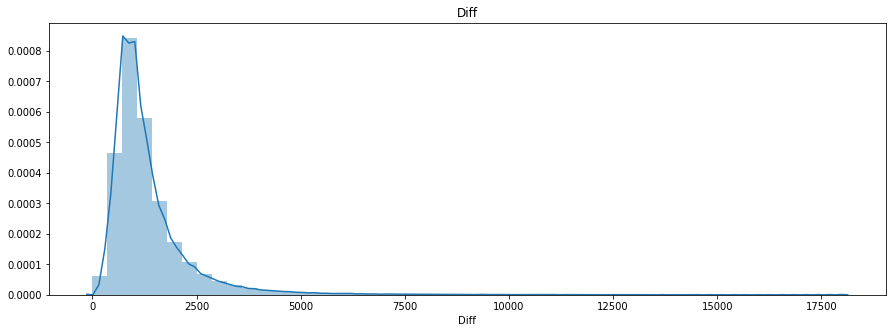

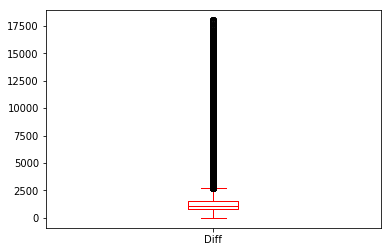

In [10]:
# Check the numerical data
numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']
print(numerical_feature)

def dist_box(df, feature_list):
    for col in feature_list:
        plt.figure(figsize=(15, 5))
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()
        
        df[col].plot(kind='box', color='red')
        plt.show()
        
print('*'*50)
print('All')
dist_box(df, numerical_feature)
print('*'*50)
print('Arrive')
dist_box(df[df['AOD'] == 'A'], numerical_feature)
print('*'*50)
print('Departure')
dist_box(df[df['AOD'] == 'D'], numerical_feature)

In [12]:
# 날짜에서 월 데이터만 추출
df['DAY'] = df['DAY'].dt.month

#df['Diff'] = (pd.to_datetime(df['ATT'],format= '%H:%M') - pd.to_datetime(df['STT'],format= '%H:%M'))
#.dt.seconds.astype('int64')

# 시간에서 시 데이터만 추출
df['ATT'] = pd.to_datetime(df['ATT'],format= '%H:%M').dt.hour
df['STT'] = pd.to_datetime(df['STT'],format= '%H:%M').dt.hour

df.head()

,DAY,FLT,AOD,STT,ATT,DLY,금,목,수,월,...,ARP8_ARP15,ARP8_ARP2,ARP8_ARP3,ARP8_ARP7,ARP9_ARP1,ARP9_ARP15,ARP9_ARP2,ARP9_ARP3,ARP9_ARP6,Diff
0,1,A1901,D,6,6,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,480
1,1,A1905,D,6,6,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,600
2,1,L1751,D,6,6,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,600
3,1,F1201,D,6,6,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,540
4,1,A1900,D,6,6,N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,420


In [13]:
from sklearn import preprocessing

# DLY도 1과 0으로 데이터 처리
le = preprocessing.LabelEncoder()
df[['DLY']] = le.fit_transform(df[['DLY']])
    
    
df.info()

C:\Users\82105\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 976920 entries, 0 to 987708
Columns: 141 entries, DAY to Diff
dtypes: int32(1), int64(4), object(2), uint8(134)
memory usage: 180.7+ MB


In [14]:
# 일단 FLT는 처리할 방법이 없어서 삭제해놓음
df.drop(['FLT'], axis=1, inplace = True)

In [15]:
# 도착, 출발 데이터 분리
df_A = df[df['AOD']=='A']
df_D = df[df['AOD']=='D']

# AOD column삭제 
df_A = df_A.drop(['AOD'],axis = 1)
df_D = df_D.drop(['AOD'],axis = 1)

In [16]:
df_A.head(5)

,DAY,STT,ATT,DLY,금,목,수,월,일,토,...,ARP8_ARP15,ARP8_ARP2,ARP8_ARP3,ARP8_ARP7,ARP9_ARP1,ARP9_ARP15,ARP9_ARP2,ARP9_ARP3,ARP9_ARP6,Diff
27,1,7,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-780
30,1,7,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-600
31,1,7,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-420
34,1,7,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-480
37,1,7,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-180


In [17]:
def makeTestSet(df):
    from sklearn.model_selection import train_test_split, KFold
    X = df.drop(['DLY','ATT','Diff'], axis = 1)
    y = df['DLY']
        
    X_tr, X_t, y_tr, y_t = train_test_split(X,y, test_size= 0.3, random_state = 42)
    
    print("X_train set--------------------")
    print("Shape:",X_tr.shape)
    print("Target:")
    print(y_tr.value_counts())
    print()
      
    print("X_test set info-----------------")
    print("Shape:",X_t.shape)
    print("Target:")
    print(y_t.value_counts())
    print()

    return [X_tr, X_t, y_tr, y_t]

In [18]:
X_train_A, X_test_A, y_train_A, y_test_A = makeTestSet(df_A)
X_train_D, X_test_D, y_train_D, y_test_D = makeTestSet(df_D)

X_train set--------------------
Shape: (342398, 136)
Target:
0    319231
1     23167
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (146743, 136)
Target:
0    137000
1      9743
Name: DLY, dtype: int64

X_train set--------------------
Shape: (341445, 136)
Target:
0    281458
1     59987
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (146334, 136)
Target:
0    120519
1     25815
Name: DLY, dtype: int64



In [20]:
def imbalance (X_train, y_train):

    from sklearn.datasets import make_classification
    from sklearn.decomposition import PCA
    from imblearn.over_sampling import SMOTE

    # 모델설정
    sm = SMOTE(ratio='auto', kind='regular')

    # train데이터를 넣어 복제함
    X_resampled, y_resampled = sm.fit_sample(X_train,list(y_train))

    print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))
    
    return [X_resampled, y_resampled]

In [26]:
############# 변수 중요도 섹션
def feature_importance(X_train, y_train, X_test, y_test):
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.model_selection import KFold, cross_val_score    
    
    #### Skew Data처리할거면 주석 해제하기!!
    X_train, y_train = imbalance(X_train, y_train)
    
    
    log_rg = LogisticRegression().fit(X_train, y_train)
    cross_val_score(log_rg, X_train, y_train, cv=5)
    log_rg.score(X_test, y_test)
    print(classification_report(y_test, log_rg.predict(X_test)))

    # X column 개수 출력
    #print(len(X.columns)) 

    # 변수 중요도 
   # feature_importance_lr = pd.DataFrame(zip(X_train.columns.values, abs(log_rg.coef_.ravel())))
    #feature_importance_lr.columns = ['feature', 'coef']
    #feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
    #feature_importance_lr = feature_importance_lr.reset_index().drop(['index'], axis=1)
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(feature_importance_lr)
    return

In [27]:
# 도착(A) 데이터만!!
feature_importance(X_train_A,y_train_A, X_test_A, y_test_A)

Using TensorFlow backend.


After OverSampling, the shape of train_X: (638462, 136)
After OverSampling, the shape of train_y: (638462, 136) 

After OverSampling, counts of label '1': 319231
After OverSampling, counts of label '0': 319231


C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

           0       0.94      0.80      0.87    137000
           1       0.11      0.33      0.16      9743

    accuracy                           0.77    146743
   macro avg       0.52      0.56      0.51    146743
weighted avg       0.89      0.77      0.82    146743



In [28]:
# 출발(D) 데이터만 !!!
feature_importance(X_train_D,y_train_D, X_test_D, y_test_D)

After OverSampling, the shape of train_X: (562916, 136)
After OverSampling, the shape of train_y: (562916, 136) 

After OverSampling, counts of label '1': 281458
After OverSampling, counts of label '0': 281458


C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

              precision    recall  f1-score   support

           0       0.87      0.66      0.75    120519
           1       0.26      0.54      0.35     25815

    accuracy                           0.64    146334
   macro avg       0.56      0.60      0.55    146334
weighted avg       0.76      0.64      0.68    146334



In [35]:
def runModel (X_train, y_train, X_test, y_test):
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
    from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
    from sklearn.model_selection import GridSearchCV
    
    # 사용되는 알고리즘
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import SVC
    from xgboost import XGBClassifier

     ## Skew Data처리할거면 주석 풀기!!
    X_train, y_train = imbalance(X_train, y_train)
    
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('XGB', XGBClassifier()))

    
    # 평가
    results = []
    names = []
    scoring = 'recall'

    seed = 7
    for name, model in models:
        # K-Fold
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        # Hold out 
        model.fit(X_train, y_train)
        y_predict = pd.Series(model.predict(X_test))

        # Resets index to compare original test data with predicted data
        y_test = y_test.reset_index(drop=True)
        y_predict = y_predict.reset_index(drop=True)

        plt.figure(figsize=(15, 5))
        plt.scatter(range(y_test.shape[0]), y_test, c='gray')
        plt.scatter(range(y_predict.shape[0]), y_predict , c='r')
        diff = abs(y_test - y_predict)
        plt.bar(range(diff.shape[0]), diff, color='gray')
        plt.title('Result - Original comparsion')
        plt.legend(['Original', 'Predict'])
        plt.show()

        print(model.score(X_test, y_test))
        print('-' * 50)
        
     # boxplot algorithm comparison
    fig = plt.figure(figsize=(11,6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    
    return


After OverSampling, the shape of train_X: (562916, 136)
After OverSampling, the shape of train_y: (562916, 136) 

After OverSampling, counts of label '1': 281458
After OverSampling, counts of label '0': 281458


C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

LR: 0.583264 (0.061157)


C:\Users\82105\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


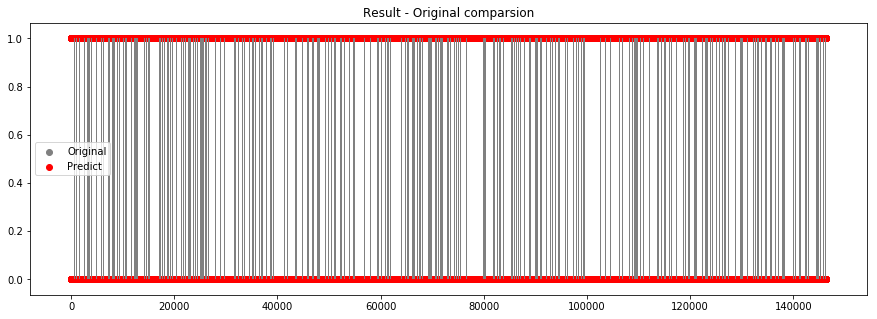

0.6405483346317329
--------------------------------------------------


C:\Users\82105\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\82105\Anacond

LDA: 0.575285 (0.064120)


C:\Users\82105\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


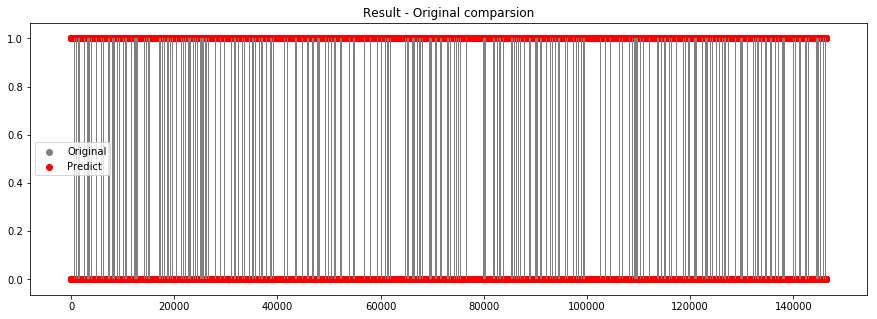

0.6434594831003048
--------------------------------------------------


In [ ]:
runModel (X_train_D,y_train_D, X_test_D, y_test_D)

In [ ]:

# # X and y variables
# X = df.drop(['DLY','ATT','Diff'], axis = 1)
# y = df['DLY']

# # re-scale

# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
# #scaler = RobustScaler()
# #scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
# #scaler = StandardScaler()
# X['Diff'] = scaler.fit_transform(X[numerical_feature])

# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
# from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
# from sklearn.model_selection import GridSearchCV

# # Algorithmns models to be compared
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from xgboost import XGBClassifier

# # Spliting X and y into train and test version
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, random_state = 42)

# # to feed the random state
# seed = 7

# # prepare models
# models = []
# # models.append(('LR', LogisticRegression()))
# # models.append(('LDA', LinearDiscriminantAnalysis()))
# # models.append(('KNN', KNeighborsClassifier()))
# # models.append(('CART', DecisionTreeClassifier()))
# # models.append(('NB', GaussianNB()))
# # models.append(('RF', RandomForestClassifier()))
# models.append(('SVM', SVC(gamma='auto')))
# models.append(('XGB', XGBClassifier()))

# # evaluate each model in turn
# results = []
# names = []
# scoring = 'recall'

# for name, model in models:
#     # K-Fold
#     kfold = KFold(n_splits=10, random_state=seed)
#     cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

#     # Hold out 
#     model.fit(X_train, y_train)
#     y_predict = pd.Series(model.predict(X_test))

#     # Resets index to compare original test data with predicted data
#     y_test = y_test.reset_index(drop=True)
#     y_predict = y_predict.reset_index(drop=True)
    
#     plt.figure(figsize=(15, 5))
#     plt.scatter(range(y_test.shape[0]), y_test, c='gray')
#     plt.scatter(range(y_predict.shape[0]), y_predict , c='r')
#     diff = abs(y_test - y_predict)
#     plt.bar(range(diff.shape[0]), diff, color='gray')
#     plt.title('Result - Original comparsion')
#     plt.legend(['Original', 'Predict'])
#     plt.show()
    
#     print(model.score(X_test, y_test))
#     print('-' * 50)
        
# # boxplot algorithm comparison
# fig = plt.figure(figsize=(11,6))
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

In [ ]:
# # 그냥 정규화 해본 것....
# # 해보았을 때 
# '''
# MIN:  -1680.0 (28분)
# MAX:  2820.0 (47분)
# 이 정규분포 상으로 나옴
# '''

# # remove the outlier of numerical data using IQR
# for col in numerical_feature:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     print('Q1: ', Q1)
#     print('Q3: ', Q3)
#     print(col, IQR)
#     df =  df[(df[col] >= (Q1 - 1.5 * IQR))
#             & (df[col] <= (Q3 + 1.5 * IQR))]
    
#     # df[col] = np.log1p(df[col]) # skewed data 처리
#     # 안하는게 정확도가 제일 높음.  
    
# print('*'*50)
# print('All')
# dist_box(df, numerical_feature)
# print('*'*50)
# print('Arrive')
# dist_box(df[df['AOD'] == 'A'], numerical_feature)
# print('*'*50)
# print('Departure')
# dist_box(df[df['AOD'] == 'D'], numerical_feature)

# print('MIN: ', min(df['Diff']))
# print('MAX: ', max(df['Diff']))


# df.info() #932136개 데이터
